<a href="https://colab.research.google.com/github/songqsh/LCSS2020/blob/master/src/hjb_1d_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  9 20:51:46 2020

@author: songqsh

Section 1.2.2 of 191206HJB.pdf
"multidimensional pde with quadratic solution"

"""

#import ipdb

###inputs begin

#configurations for PDE

import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt   
import torch
import torch.nn as nn




class Pde:
    def __init__(self, n_dim = 2, verbatim = False):
        self.n_dim = n_dim    
        self.lam = 0.
        self.domain = [0,1]
        
        if verbatim == True:
            print('>>> n_dim: '+str(n_dim))
            print('>>> domain: ' + str(self.domain))
            
    drift = lambda self,s,a: a
    
    run_cost = lambda self,s,a: (
            self.n_dim + sum([s1**2 for s1 in s])*2.0 
            + sum([a1**2 for a1 in a])/2.0
            )
    
    term_cost = lambda self,s: - sum([s1**2 for s1 in s]) 
    exact_soln = lambda self,s: - sum([s1**2 for s1 in s]) 


class Mdp(Pde):
    def __init__(self, n_dim = 2, n_mesh = 8, verbatim = False):
        super().__init__(n_dim, verbatim)
        self.n_mesh= n_mesh  
        self.totn_mesh = self.n_mesh*(self.domain[1]-self.domain[0])
        self.h_mesh = 1./self.n_mesh #mesh size
        self.v_shape = tuple([self.totn_mesh+ 1,]*self.n_dim)
        if verbatim == True:
            print('>>> n_mesh: '+str(n_mesh)
                  +' totn_mesh: '+ str(self.totn_mesh))


    #input: list of index
    #return: physicial coordinate
    def i2s(self,ix): 
        return [x * self.h_mesh+self.domain[0] for x in ix]
    
    def is_interior(self,ix):
        return all(map(lambda a: 0<a<self.totn_mesh, ix))
        
    #input: lists of index and action
    #return: discount rate, running cost, list of next index, list of probability
    def step(self, ix, a, fd='cfd'):
        ix = list(ix)
        s = self.i2s(ix)
        b = Pde.drift(Pde, s, a)
        if fd=='cfd':
            lam = self.n_dim/(self.n_dim+self.lam*(self.h_mesh**2))
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/self.n_dim
            
            ix_next = []; pr_next= []
            #cfd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+1.*self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-1.*self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
        elif fd=='ufd':
            c = self.n_dim+sum([abs(b1) for b1 in b])*self.h_mesh
            b_plus = [(abs(b1)+b1)/2. for b1 in b]
            b_minus = [(abs(b1)-b1)/2. for b1 in b]
            lam = c/(c+self.h_mesh**2*self.lam)
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/c
            ix_next = []; pr_next= []
            #ufd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+2.*self.h_mesh*b_plus[i])/(c*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b_minus[i])/(c*2.0) 
                    pr_next += [pr1,]        
        return lam, run_cost_h, ix_next, pr_next
    
    def step_random(self, ix, a, fd='cfd'):
        lam, run_cost, ix_next, pr_next = self.step(ix, a, fd)
        ix_next_rand = random.choices(ix_next, pr_next, k = 1)
        return lam, run_cost, ix_next_rand[0]    
    

 
####################supplemental tools
import itertools

def deep_iter(*shape):
    iters = (range(i) for i in shape)
    return itertools.product(*iters)


#product of a list
def product(l):
    out = 1
    for x in l:
        out *= x
    return out

############  solvers

class Solver(Mdp):
    def __init__(self, n_dim = 1, n_mesh = 8, fd = 'ufd', verbatim = False):
        super().__init__(n_dim, n_mesh, verbatim)
        self.fd = fd
        #value iteration init
        self.v = np.zeros(self.v_shape) #init
        self.as_ratio= 3
        self.a_space = tuple([self.as_ratio*self.totn_mesh+1,]*n_dim)
        self.p_shape = tuple(list(self.v_shape)+[self.n_dim,])
        self.policy = np.zeros(self.p_shape) #init
        self.tol = 1e-5; self.max_iter = 1000
        
        #boundary value
        for ix in deep_iter(*self.v_shape):
            if not self.is_interior(ix):
                self.v[ix] = self.term_cost(self.i2s(ix))
    
    
    def i2a(self, ix):
        ix = list(ix)
        return [ix1*self.h_mesh+self.as_ratio*self.domain[0] for ix1 in ix]
    
    #input:
        #list of index and action
    #return:
        #q_val assuming v is value
    def q_val(self, ix, a):
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.v[tuple(ix1)]
        out *= lam
        return out

    #input:
        #list of index
    #return:
        #list of optimal action
        #corresponding q-value assuming v is value
    def greedy(self, ix):
        a_ix = [0,]*self.n_dim; out_v = self.q_val(ix, self.i2a(a_ix))
        for a_ix1 in deep_iter(*self.a_space):
            out_v1 = self.q_val(ix, self.i2a(a_ix1))
            if out_v1 < out_v:
                a_ix = a_ix1; out_v = out_v1
        return self.i2a(a_ix), out_v
                
        

    def value_iter(self):    
        for n_iter in range(self.max_iter):
            v_cp = np.copy(self.v)
            err = 0.
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    out_a, out_v = self.greedy(ix)
                    self.policy[ix] = out_a; self.v[ix] = out_v
                    err += (v_cp[ix]-out_v)**2

            if err<self.tol:
                break
        return err, n_iter
    
    def policy_iter(self):
        policy_stable = False
        n_iter = 0
        while not policy_stable:
            n_iter +=1
            #policy evaluation
            pe = PolicyEvaluation(self.policy, n_dim = self.n_dim, 
                                  n_mesh=self.n_mesh, fd = self.fd)
            err1, n_iter1 = pe.solver()   
            self.v = np.copy(pe.v)
            
            #policy improvement
            policy_err = 0
            policy_cp = np.copy(self.policy)
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    out_a, _ = self.greedy(ix)
                    self.policy[ix] = out_a
                    policy_err += sum(np.power(policy_cp[ix] - out_a,2))
                    
            if policy_err<1e-2:
                policy_stable = True
            if n_iter>self.max_iter:
                break
        return policy_err, n_iter
    
    def plot1d(self):
        if self.n_dim==1:
            x_cod = np.zeros(self.v_shape)
            exact_val = np.zeros(self.v_shape)
            for ix in deep_iter(*self.v_shape):
                x_cod[ix] = self.i2s(list(ix))[0]
                exact_val[ix] = self.exact_soln(self.i2s(list(ix)))
                                
            plt.plot(x_cod, self.v, '--', label='aproximation')
            plt.plot(x_cod, exact_val, label='exact solution')
            plt.legend()
            plt.show()
    
    def plot2d(self):
        if self.n_dim==2:
            from matplotlib import cm
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure()
            ax = fig.gca(projection=Axes3D.name)
            x_cod = np.zeros(self.v_shape)
            y_cod = np.zeros(self.v_shape)
            z = self.v
            for ix in deep_iter(*self.v_shape):
                x_cod[ix] = agt1.i2s(list(ix))[0]
                y_cod[ix] = agt1.i2s(list(ix))[1]
            # Plot the surface.
            ax.plot_surface(x_cod, y_cod, z, 
                                      cmap=cm.coolwarm,
                                      linewidth=0, antialiased=False)
            plt.show()
                            
            
            
            
                    
    def l2err(self):
        err = 0.
        exact_val = np.zeros(agt1.v_shape)
        
        for ix in deep_iter(*agt1.v_shape):
            exact_val[ix] = agt1.exact_soln(agt1.i2s(list(ix)))
            err += (exact_val[ix]- agt1.v[ix])**2
        err = err/product(agt1.v_shape)
        return math.sqrt(err)        
    
    


###begin policy evaluation


class PolicyEvaluation(Mdp):
    def __init__(self, policy, n_dim = 1, n_mesh = 8, fd = 'ufd'):
        super().__init__(n_dim, n_mesh)
        self.fd = fd
        #value iteration init
        self.v = np.zeros(self.v_shape) #init
        self.p_shape = tuple(list(self.v_shape)+[self.n_dim,])
        self.policy = policy #init
        if not self.p_shape==np.shape(self.policy):
            print('>>>alert: policy shape is not right')
            
        self.tol = 1e-5; self.max_iter = 1000
        
        #boundary value
        for ix in deep_iter(*self.v_shape):
            if not self.is_interior(ix):
                self.v[ix] = self.term_cost(self.i2s(ix))
    
    
    #input:
        #list of index and method
    #return:
        #rhs_val assuming v is value
    def rhs_val(self, ix):
        a = self.policy[ix]
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.v[tuple(ix1)]
        out *= lam
        return out


    def solver(self):    
        for n_iter in range(self.max_iter):
            v_cp = np.copy(self.v)
            err = 0.
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    v_cp[ix] = self.rhs_val(ix)
                    err += (v_cp[ix]-self.v[ix])**2
            self.v = np.copy(v_cp)
            if err<self.tol:
                break
        return err, n_iter


###end policy evaluation
        





########solver__nn starts here

class solver_nn(Mdp):
    def __init__(self, n_dim = 1, n_mesh = 8, fd = 'cfd', n_neuron = 32):
        super().__init__(n_dim, n_mesh)
        self.fd = fd
        self.as_ratio=3
        self.a_space = tuple([self.as_ratio*self.totn_mesh+1,]*n_dim)
        self.n_neuron = n_neuron
        h = [self.n_dim,self.n_neuron]
        self.vf = nn.Sequential(
                nn.Linear(h[0], h[1]),
                nn.ReLU(),
                #nn.LeakyReLU(),
                #nn.Sigmoid(),
                #nn.Tanh(),
                #nn.Linear(h[1], h[2]),
                #nn.Sigmoid(),
                #nn.ReLU(),
                #nn.LeakyReLU(),
                #nn.Tanh(),
                nn.Linear(h[-1], 1),
                ) 
        print(self.vf)
        
   
    
    def i2a(self, ix):
        ix = list(ix)
        return [ix1*self.h_mesh+self.as_ratio*self.domain[0] for ix1 in ix]    
    
    
    #input:
        #list of index and action, method
    #return:
        #q_val assuming v is value
    def q_val(self, ix, a):
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.vf(torch.FloatTensor(self.i2s(ix1)))
        out *= lam
        return out
    

    #input:
        #list of index
    #return:
        #list of optimal action
        #corresponding q-value assuming v is value
    def greedy(self, ix):
        a_ix = [0,]*self.n_dim; out_v = self.q_val(ix, self.i2a(a_ix))
        for a_ix1 in deep_iter(*self.a_space):
            out_v1 = self.q_val(ix, self.i2a(a_ix1))
            if out_v1 < out_v:
                a_ix = a_ix1; out_v = out_v1
        return self.i2a(a_ix), out_v
                
    
    def value_gd1(self, n_epoch = 50, lr=.001, w_in = 30., w_out =1.):
        
        epoch_per_print = 20
        epoch_buffer = []
        loss_buffer = []
        start_time = time.time()
        
        flag = False #to stop
        epoch =0
        loss = torch.FloatTensor([100.,])
        
        while not flag:
            epoch +=1
            lossp = loss.item()
            loss = torch.FloatTensor([0.,])           
            for ix in deep_iter(*self.v_shape):
                ix_s = self.i2s(ix)
                v1 = self.vf(torch.FloatTensor(ix_s))
                if self.is_interior(ix):
                    loss+= w_in*(self.greedy(ix)[1]-v1)**2
                else:
                    loss+= w_out*(self.term_cost(ix_s) - 
                              self.vf(torch.FloatTensor(ix_s)))**2                   
            
            optimizer = torch.optim.SGD(
                    self.vf.parameters(), lr, momentum=.8)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_buffer +=[epoch]
            loss_buffer += [loss.item()]
            
            
            if (epoch) % epoch_per_print == 0:
              print('Epoch '+ str(epoch) + ', Loss: '+ str(loss.item()))
            
            
            flag = (loss.item()<1e-5 or 
                    abs(lossp - loss.item())<1e-8 or
                    epoch>n_epoch
                    )
 
        end_time = time.time()
        return end_time - start_time, loss.item(), epoch, epoch_buffer, loss_buffer
    

    
    
        
    def err_l2(self):
        err = 0
        for ix in deep_iter(*self.v_shape):
            ix_s = self.i2s(list(ix))
            exact_val = self.exact_soln(ix_s)
            approx_val = self.vf(torch.FloatTensor(ix_s)).item()
            err += (exact_val - approx_val)**2
        err = err/product(self.v_shape)
        return math.sqrt(err)
        
        
    def plot1d(self):
        if self.n_dim==1:
            x_cod = np.zeros(self.v_shape)
            y1_cod = np.zeros(self.v_shape)
            y2_cod = np.zeros(self.v_shape)
            for ix in deep_iter(*self.v_shape):
                x_cod[ix] = self.i2s(list(ix))[0]
                ix_s = self.i2s(list(ix))
                y1_cod[ix] = self.vf(torch.FloatTensor(ix_s)).item()
                y2_cod[ix] = self.exact_soln(ix_s)
                
            plt.plot(x_cod, y1_cod, x_cod, y2_cod)
            plt.show()
        else:
            print('>>>>plot must be 1d<<<<')



>>>>>>>check value iteration<<<<<<<<<
>>> n_dim: 1
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 0.03324079513549805
>>>running err:6.621465903706597e-06
>>>number of iterations: 22
>>>>L2 exact err:0.0037144258967895475


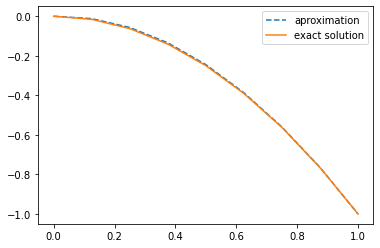

>>>>end check<<<<


In [2]:

#begin check ValueIter
print('>>>>>>>check value iteration<<<<<<<<<')

startime = time.time()
#debug: If fd = 'cfd' in the next line, it gives big error. 
agt1 = Solver(n_dim=1, n_mesh= 8, fd='cfd', verbatim = True)
err, n_iter = agt1.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt1.l2err()))


agt1.plot1d()    
agt1.plot2d()
print('>>>>end check<<<<')



 
#end check ValueIter                





In [3]:



###begin check 
print('>>>>>>>check policy evaluation<<<<<<<<<')
starttime = time.time()
pe = PolicyEvaluation(agt1.policy, n_dim = agt1.n_dim, 
                      n_mesh=agt1.n_mesh, fd = agt1.fd)
err, n_iter = pe.solver()
endtime = time.time()

print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err)+' n_iter: '+ str(n_iter))

err = 0
for ix in deep_iter(*agt1.v_shape):
    err += (pe.v[ix]- agt1.v[ix])**2
err = err/product(agt1.v_shape)
    
print('>>>>err:'+str(err))
print('>>>>>>>end check <<<<<<<<<')
####end check######################




>>>>>>>check policy evaluation<<<<<<<<<
>>>elapsed time: 0.24888014793395996
>>>running err:8.260071078708195e-06 n_iter: 41
>>>>err:4.6713612938917387e-07
>>>>>>>end check <<<<<<<<<


>>>>>>>check policy iteration vs value iteration<<<<<<<<<
>>> n_dim: 1
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 0.02443528175354004
>>>running policy err:0.0 n_iter: 3
>>>>value diff between value-iter and policy-iter:4.6713612938917387e-07


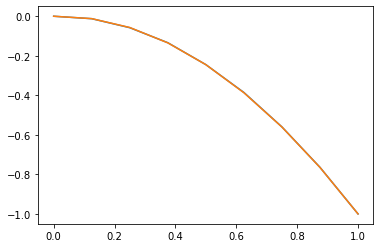

>>>end check<<<


In [4]:



#begin check policy iter, compared to value iter
print('>>>>>>>check policy iteration vs value iteration<<<<<<<<<')

startime = time.time()
agt2 = Solver(n_dim=agt1.n_dim, n_mesh= agt1.n_mesh, fd= agt1.fd, verbatim = True)
p_err, n_iter = agt2.policy_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running policy err:' +str(p_err)+' n_iter: '+ str(n_iter))

#compare value iter and policy iter 
err = 0.
for ix in deep_iter(*agt2.v_shape):
    err += (agt1.v[ix]- agt2.v[ix])**2
err = err/product(agt2.v_shape)
    
print('>>>>value diff between value-iter and policy-iter:'+str(err))



if agt2.n_dim==1:
    x_cod = np.zeros(agt2.v_shape)
    for ix in deep_iter(*agt2.v_shape):
        x_cod[ix] = agt2.i2s(list(ix))[0]
        
    plt.plot(x_cod, agt2.v, x_cod, agt1.v)
    plt.show()
    
print('>>>end check<<<')    
#end check policy iter        





>>>>>>>>>>begin check solver_nn<<<<<<<<<
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 20, Loss: 0.2046635001897812
Epoch 40, Loss: 0.10200510919094086
Epoch 60, Loss: 0.07151894271373749
Epoch 80, Loss: 0.06030870974063873
Epoch 100, Loss: 0.05501023679971695
Epoch 120, Loss: 0.051794156432151794
Epoch 140, Loss: 0.049317196011543274
Epoch 160, Loss: 0.04714759439229965
Epoch 180, Loss: 0.04506206139922142
Epoch 200, Loss: 0.04324381425976753
Epoch 220, Loss: 0.04164007306098938
Epoch 240, Loss: 0.04015424847602844
Epoch 260, Loss: 0.0387691967189312
Epoch 280, Loss: 0.03743855655193329
Epoch 300, Loss: 0.03621156886219978
Epoch 320, Loss: 0.03503281995654106
Epoch 340, Loss: 0.03389498218894005
Epoch 360, Loss: 0.03282005339860916
Epoch 380, Loss: 0.031775351613759995
Epoch 400, Loss: 0.030712833628058434
Epoch 420, Loss: 0.029699649661779404
Epoch 440, Loss: 0.0287470705807209
Epoch

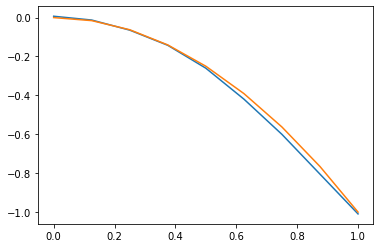

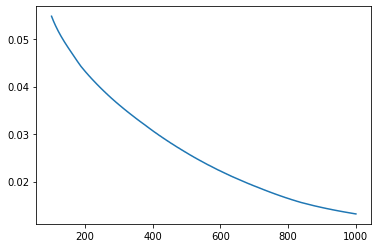

>>>>>> L2 error is 0.02119702741587964


In [5]:


##############begin check solver_nn##########
print('>>>>>>>>>>begin check solver_nn<<<<<<<<<')        
agt3 = solver_nn(n_dim=1, n_mesh= 8, fd= 'cfd', n_neuron=32)
tot_time, tot_loss, tot_iter, epoch_buffer, loss_buffer = agt3.value_gd1(
    n_epoch=1000, lr=.01, w_in = 30., w_out = 1.)  

if agt3.n_dim == 1:
    agt3.plot1d()


plt.plot(epoch_buffer[100:], loss_buffer[100:])
plt.show()
print('>>>>>> L2 error is ' + str(agt3.err_l2()))
    

    